<a href="https://colab.research.google.com/github/kiselpd/HW4_ML/blob/main/pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-talk')
plt.rcParams['figure.figsize'] = (15,10)

In [2]:
#for my GoogleDisk
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/GoogleColab/HW4

Mounted at /content/drive
/content/drive/MyDrive/GoogleColab/HW4


In [3]:
# Загружаем данные сенсоров
df_database = pd.read_csv('./data/sign_database.csv')

# Загружаем метки классов
sign_classes = pd.read_csv('./data/sign_classes.csv', index_col=0, header=0, names=['id', 'class'])

In [4]:
# Выберем одно из слов с идентификатором = 0
df_database.head()
sign0 = df_database.query('id == 0')\
                   .drop(['id'], axis=1)\
                   .set_index('time')

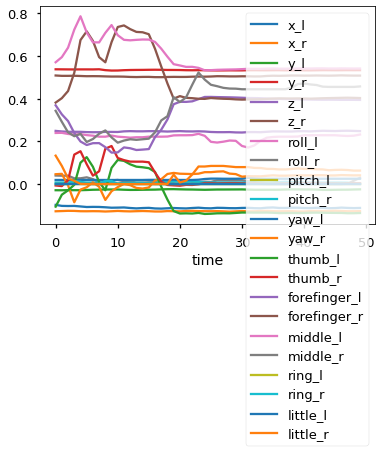

In [6]:
sign0.plot()

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
!mkdir ./data
!wget https://www.dropbox.com/s/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz?dl=0 -O ./data/tsfresh_features_filt.csv.gz
filepath = './data/tsfresh_features_filt.csv.gz'
sign_features_filtered = pd.read_csv(filepath)

mkdir: cannot create directory ‘./data’: File exists
--2022-04-27 07:28:08--  https://www.dropbox.com/s/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz [following]
--2022-04-27 07:28:09--  https://www.dropbox.com/s/raw/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5b532044c602faf03a85b3e75f.dl.dropboxusercontent.com/cd/0/inline/BkIcpwpyKzs9q0i7vhFvJz4UTm3sRPZTq2Fr5VkJ2ZKTgvTjHdl0EJiVIpvEXzKThxbgre_uiS0x5fdA4H8I-PG09qSz8hWxQSHOyOBokgU6JuDPEnHGOiYFw7owbhDmHgtcQH8KHvNDXz7rMSQplz_hnzqAcp-Wylif4JoNEs0B6w/file# [following]
--2022-04-27 07:28:09--  https://uc5b532044c602faf03a85b3e75f.

In [9]:
sign_features_filtered.shape

(2565, 11517)

In [10]:
sign_features_filtered.head()

,Unnamed: 0,ring_r__maximum,"ring_r__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""max""","ring_r__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""","ring_r__fft_coefficient__attr_""abs""__coeff_2","ring_r__linear_trend__attr_""stderr""",ring_r__quantile__q_0.9,"ring_r__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""",ring_r__variance,ring_r__standard_deviation,...,forefinger_l__large_standard_deviation__r_0.15000000000000002,little_r__symmetry_looking__r_0.15000000000000002,z_l__symmetry_looking__r_0.35000000000000003,roll_r__large_standard_deviation__r_0.25,roll_r__large_standard_deviation__r_0.45,little_r__symmetry_looking__r_0.05,pitch_l__symmetry_looking__r_0.05,z_l__large_standard_deviation__r_0.45,little_l__symmetry_looking__r_0.05,y_l__symmetry_looking__r_0.35000000000000003
0,0,0.014764,0.998626,0.000174,0.047854,0.000034,0.006166,0.000423,0.000015,0.003881,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,0.017579,0.017579,0.000180,0.045183,0.000027,0.003599,0.000397,0.000012,0.003399,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,0.043917,0.043917,0.000737,0.059952,0.000092,0.028252,0.001034,0.000142,0.011921,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,0.061037,0.061037,0.001453,0.402618,0.000127,0.047034,0.001777,0.000314,0.017728,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [20]:
# Подготовим данные на вход в модель

# признаки
X = sign_features_filtered.values

# классы
y = sign_classes.values

In [29]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123)

model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state = 123, svd_solver = "randomized", n_components = 80)),         #80
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

cv_scores = cross_val_score(model, X, y, cv = cv, scoring = 'accuracy')

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

In [30]:
cv_scores

array([0.90253411, 0.89863548, 0.91423002, 0.89083821, 0.90448343])

In [22]:
cv_scores.mean()

0.9021442495126706

In [26]:
pca_model = model["pca"]
pca_model.fit_transform(X, y)
variance = pca_model.explained_variance_ratio_
variance

array([7.39004509e-01, 1.02168199e-01, 6.03454706e-02, 5.20832011e-02,
       1.65142352e-02, 1.60063099e-02, 6.45623114e-03, 6.42239572e-03,
       9.99448343e-04, 5.40480630e-17, 2.36981962e-18, 2.16949678e-22,
       6.11516226e-24, 8.57875717e-25, 2.21369024e-25, 1.87264956e-25,
       1.32812858e-25, 1.00101492e-25, 1.38225478e-26, 5.72153703e-27,
       4.31703403e-27, 3.96579642e-27, 2.16468646e-27, 1.80219486e-27,
       1.52902557e-27, 1.39752807e-27, 1.13969953e-27, 5.69806235e-28,
       1.84095172e-28, 1.28583900e-28, 1.06505772e-28, 9.81429107e-29,
       9.69168001e-29, 7.30737696e-29, 6.33013893e-29, 4.53597298e-29,
       4.07599242e-29, 2.70045792e-29, 2.46809110e-29, 2.24705683e-29,
       2.19042907e-29, 2.03635680e-29, 1.61863665e-29, 1.53684526e-29,
       1.37176060e-29, 1.14351040e-29, 1.04286732e-29, 1.03350561e-29,
       9.92843242e-30, 9.12515857e-30, 8.60906477e-30, 8.45744287e-30,
       8.17126395e-30, 7.57636523e-30, 7.17546590e-30, 7.08876015e-30,
      

In [27]:
variance.cumsum()

array([0.73900451, 0.84117271, 0.90151818, 0.95360138, 0.97011561,
       0.98612192, 0.99257816, 0.99900055, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [28]:
variance.mean()

0.012499999999999999